# USDM & SPI - Investigate Temporal

a. stein 5.25.2022

The `analysis/usdm_spi_compare_temporal.ipynb` described rather poor fitting between USDM and SPI temporally ... even when spatial resolution was increased. This is surprising given how SPI should heavily influence a lot of drought metrics, including USDM. In this notebook I'll see if I can tease apart why this mismatch is occuring.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

# grab the product already made
caf_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI_caf.nc')
caf_ds

<xarray.Dataset>
Dimensions:               (index: 1148)
Coordinates:
  * index                 (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
Data variables: (12/56)
    USDM_neutral_wet      (index) float64 ...
    USDM_D0               (index) float64 ...
    USDM_D1               (index) float64 ...
    USDM_D2               (index) float64 ...
    USDM_D3               (index) float64 ...
    USDM_D4               (index) float64 ...
    ...                    ...
    spi_270d_D1           (index) float64 ...
    spi_270d_D2           (index) float64 ...
    spi_270d_D3           (index) float64 ...
    spi_270d_D4           (index) float64 ...
    USDM Date             (index) datetime64[ns] ...
    SPI Date              (index) datetime64[ns] ...
Attributes:
    description:  Fraction of total non-nan area that is in that USDM drought...

Let's start by making some stacked plots

In [3]:
usdm_colors=["white","yellow","navajowhite","orange","crimson","darkred"]

In [4]:
[0]*caf_ds['index']

<xarray.DataArray 'index' (index: 1148)>
array([0, 0, 0, ..., 0, 0, 0])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 1141 1142 1143 1144 1145 1146 1147

In [5]:
usdm_dates = caf_ds['USDM Date'].values

### Stacked Time Series

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


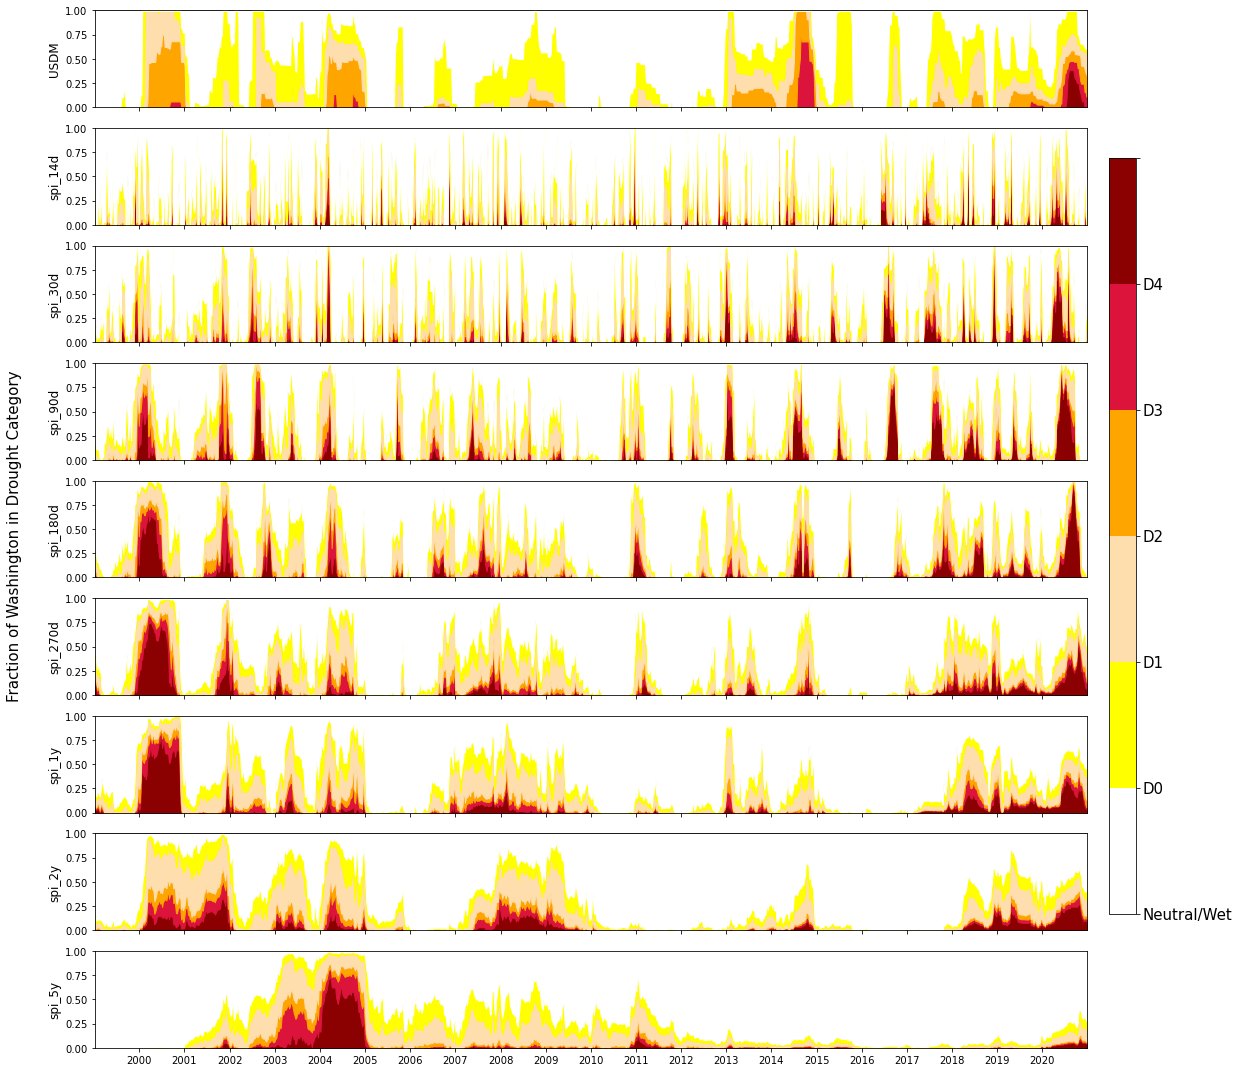

In [6]:
fig, axs = plt.subplots(len(dm_vars), 1, figsize=(15,15), sharex=True)

for ax, dm_var in zip(axs.ravel(), dm_vars):
    cumulative = np.zeros(len(caf_ds['index']))
    for cat, color in zip(np.flip(cats), np.flip(usdm_colors)):
        ax.fill_between(usdm_dates, cumulative, caf_ds[f'{dm_var}_{cat}'].values+cumulative, color=color)
        cumulative += caf_ds[f'{dm_var}_{cat}'].values

    ax.set_ylim(0,1)
    ax.set_xlim(usdm_dates[0], usdm_dates[-1])
    ax.set_ylabel(dm_var, fontsize=12)

    # helps point out missing data
    ax.set_facecolor('k')

    # fix the formating to only show hours
    formatter = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(formatter)
    # set the frequency to not crowd the axis
    ax.set_xticks(pd.date_range(usdm_dates[0], usdm_dates[-1], freq='1Y'))

fig.supylabel('Fraction of Washington in Drought Category', size=15, x=-0.01)

cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cmap = ndplot.usdm_cmap()
bounds = np.linspace(-1, 5, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, ticks=bounds)
cbar.set_ticklabels(['Neutral/Wet', 'D0', 'D1', 'D2', 'D3', 'D4', ''], size=15)

plt.tight_layout()

Well that's kind of interesting. What if I look for lag/autocorrelation? See if there is a delayed signal ..

Hang on, why is SPI so high in D4?

In [7]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import ccf

In [8]:
# check how much data we have for informing lagging
len(caf_ds['USDM Date'])

1148

### Autocorrelation

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


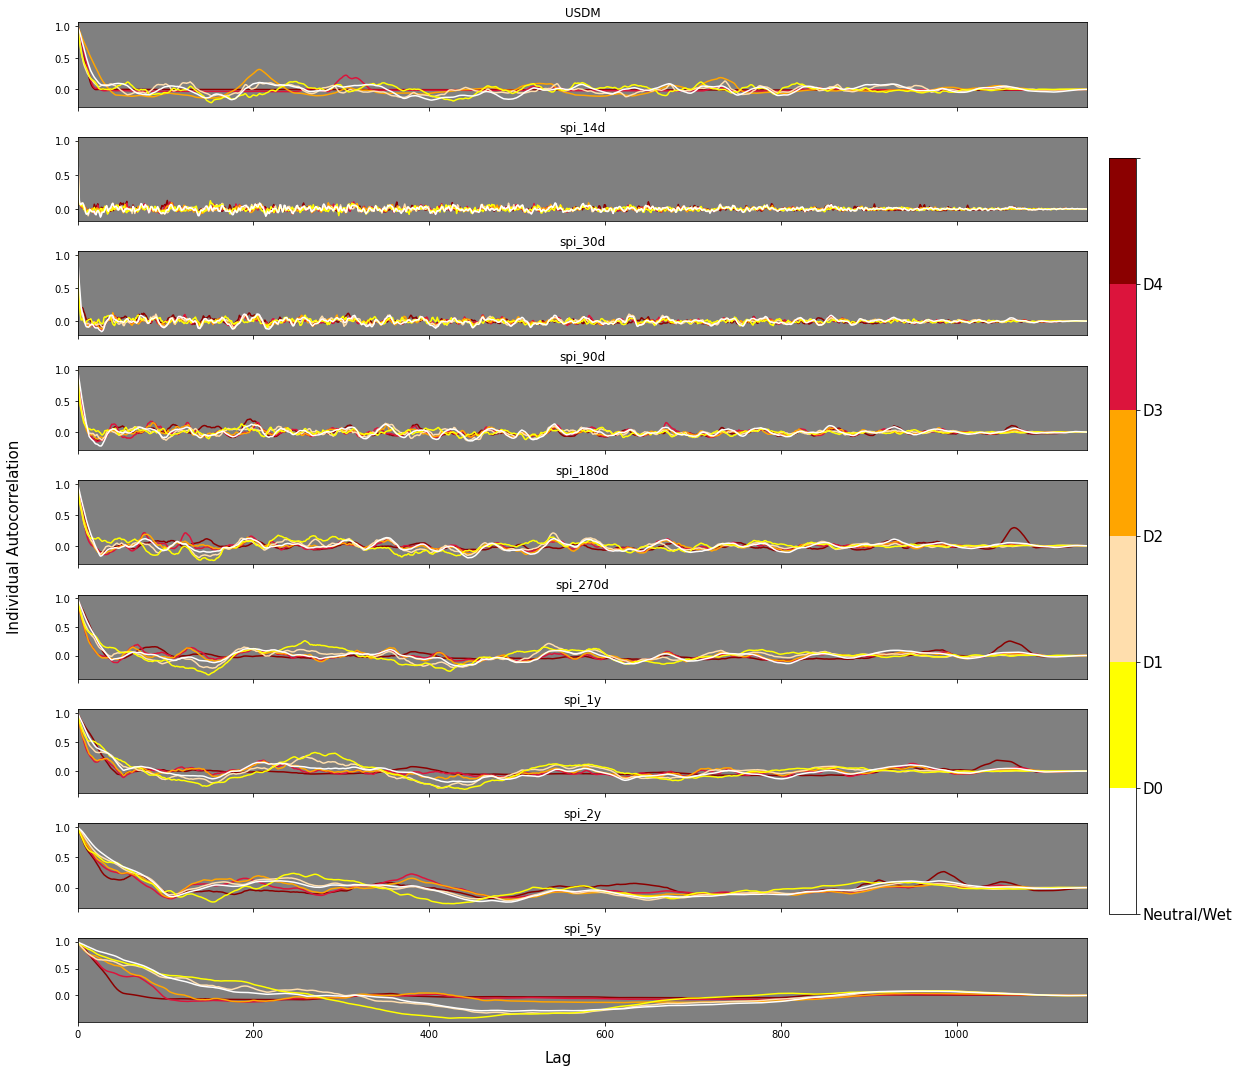

In [9]:
fig, axs = plt.subplots(len(dm_vars), 1, figsize=(15,15), sharex=True)


nlags = len(caf_ds['USDM Date'])

for ax, dm_var in zip(axs.ravel(), dm_vars):
    for cat, color in zip(np.flip(cats), np.flip(usdm_colors)):
        ax.plot(np.arange(0, nlags), acf(caf_ds[f'{dm_var}_{cat}'], nlags=nlags), color=color)

    ax.set_facecolor('grey')
    ax.set_title(dm_var)
    ax.set_xlim(0, nlags)
    
cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cmap = ndplot.usdm_cmap()
bounds = np.linspace(-1, 5, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, ticks=bounds)
cbar.set_ticklabels(['Neutral/Wet', 'D0', 'D1', 'D2', 'D3', 'D4', ''], size=15)

fig.supylabel('Individual Autocorrelation', size=15, x=-0.01)
fig.supxlabel('Lag', size=15)

plt.tight_layout()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


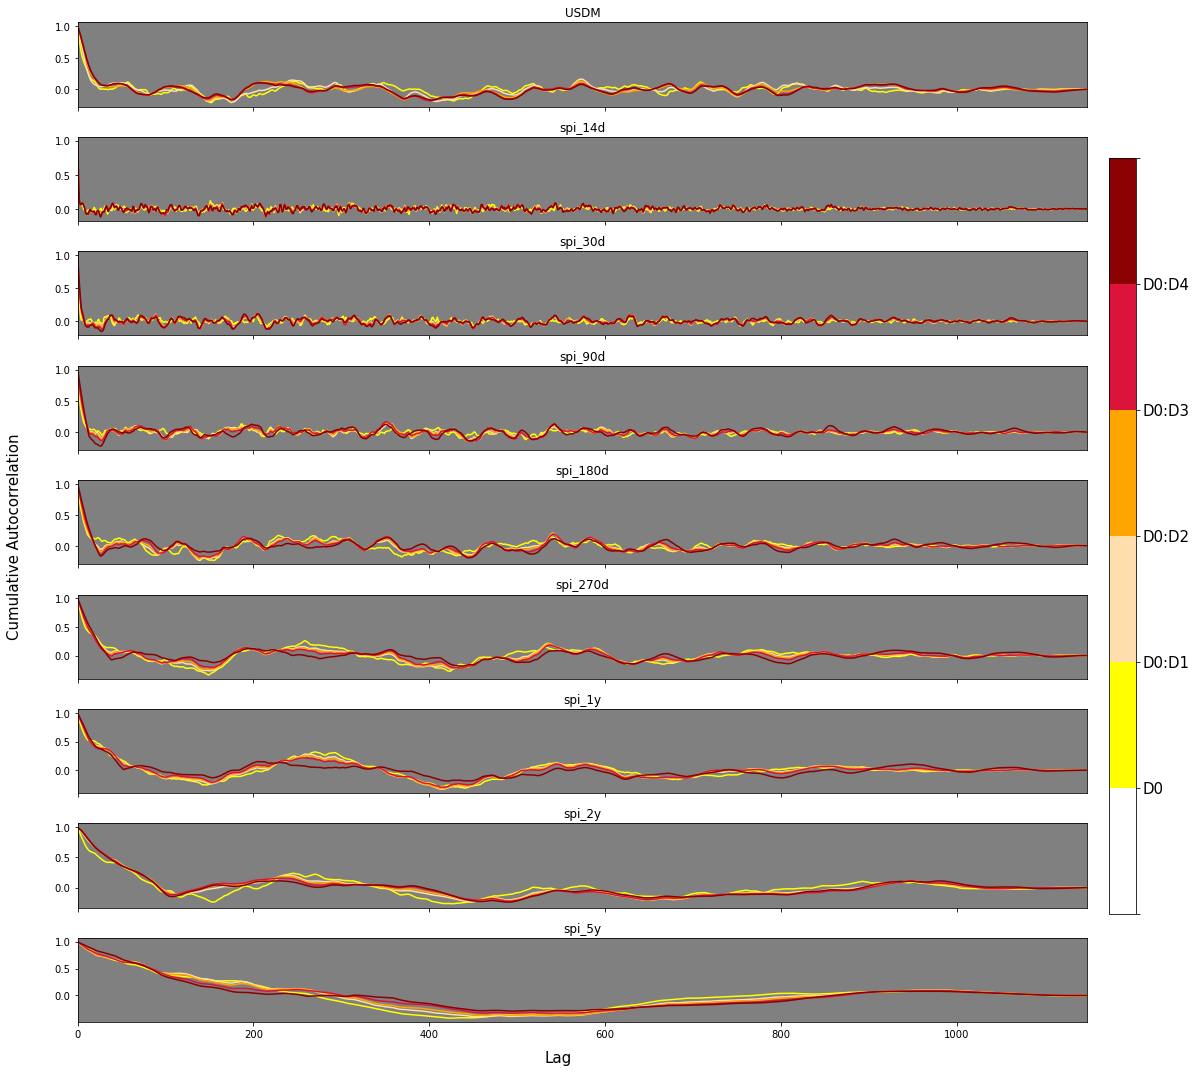

In [10]:
fig, axs = plt.subplots(len(dm_vars), 1, figsize=(15,15), sharex=True)


nlags = len(caf_ds['USDM Date'])

for ax, dm_var in zip(axs.ravel(), dm_vars):
    cumulative = np.zeros(len(caf_ds['index']))
    for cat, color in zip(cats[1:], usdm_colors[1:]):
        cumulative += caf_ds[f'{dm_var}_{cat}']
        ax.plot(np.arange(0, nlags), acf(cumulative, nlags=nlags), color=color)

    ax.set_facecolor('grey')
    ax.set_title(dm_var)
    ax.set_xlim(0, nlags)
    
cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cmap = ndplot.usdm_cmap()
bounds = np.linspace(-1, 5, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, ticks=bounds)
cbar.set_ticklabels(['', 'D0', 'D0:D1', 'D0:D2', 'D0:D3', 'D0:D4', ''], size=15)

fig.supylabel('Cumulative Autocorrelation', size=15, x=-0.01)
fig.supxlabel('Lag', size=15)

plt.tight_layout()

### Cross-Correlation

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


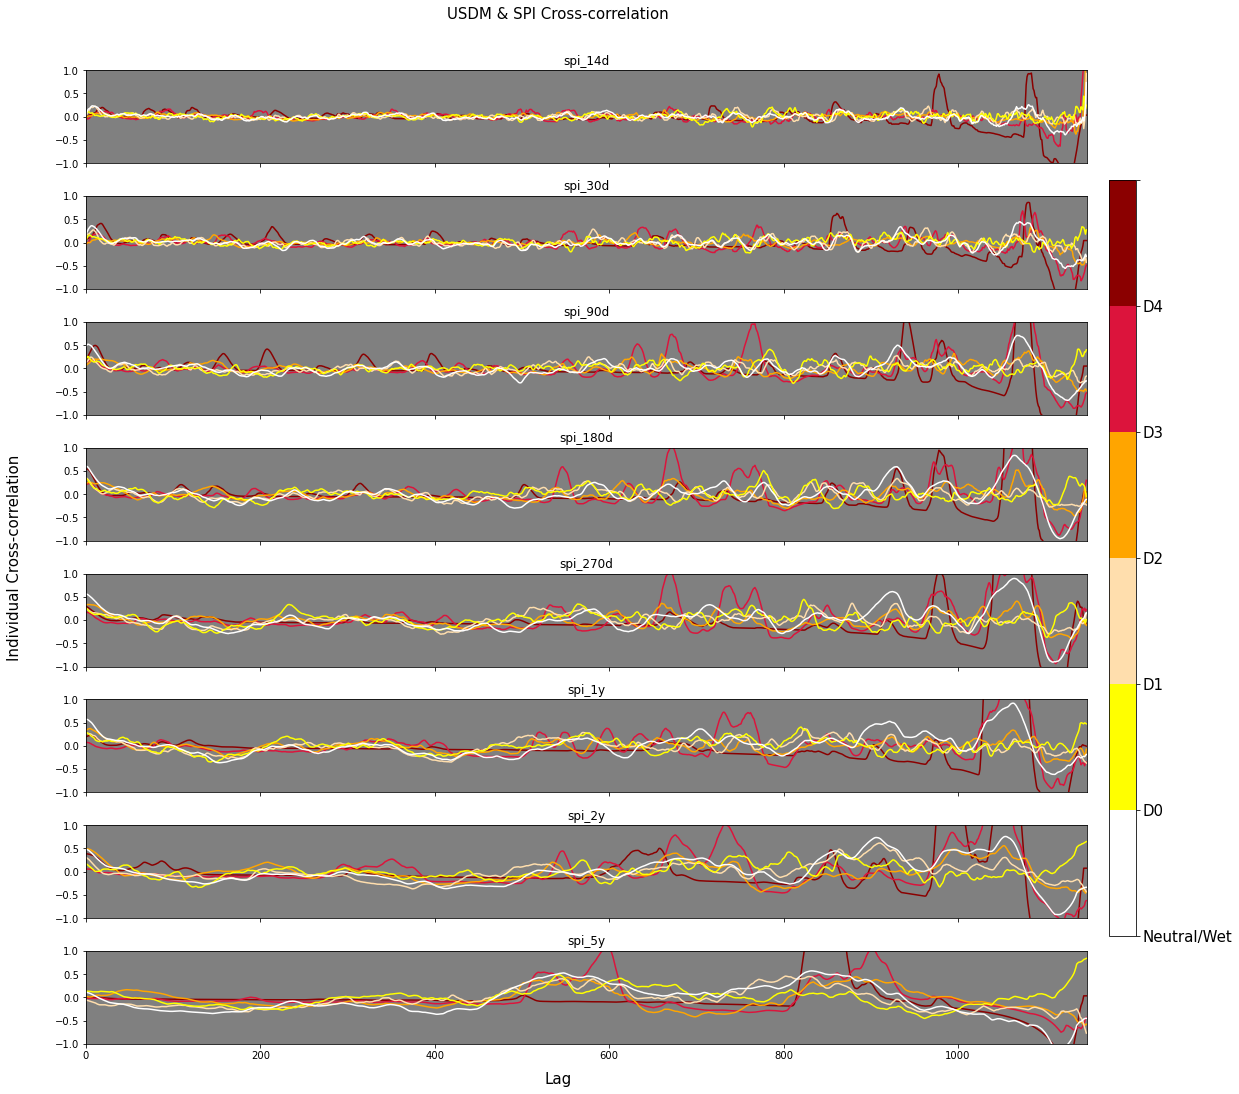

In [11]:
fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(15,15), sharex=True)


nlags = len(caf_ds['USDM Date'])

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    for cat, color in zip(np.flip(cats), np.flip(usdm_colors)):
        ax.plot(np.arange(0, nlags), ccf(caf_ds[f'USDM_{cat}'], caf_ds[f'spi_{spi_int}_{cat}']), color=color)
        #ax.plot(np.arange(0, nlags), ccf(caf_ds[f'spi_{spi_int}_{cat}'], caf_ds[f'USDM_{cat}']), color=color)

    ax.set_facecolor('grey')
    ax.set_title(f'spi_{spi_int}')
    ax.set_ylim(-1,1)
    ax.set_xlim(0, nlags)
    
cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cmap = ndplot.usdm_cmap()
bounds = np.linspace(-1, 5, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, ticks=bounds)
cbar.set_ticklabels(['Neutral/Wet', 'D0', 'D1', 'D2', 'D3', 'D4', ''], size=15)

fig.supylabel('Individual Cross-correlation', size=15, x=-0.01)
fig.supxlabel('Lag', size=15)
fig.suptitle('USDM & SPI Cross-correlation', size=15, y=1.01)

plt.tight_layout()

In [12]:
1148/52

22.076923076923077

In [13]:
caf_ds['USDM Date']

<xarray.DataArray 'USDM Date' (index: 1148)>
array(['2000-01-04T00:00:00.000000000', '2000-01-11T00:00:00.000000000',
       '2000-01-18T00:00:00.000000000', ..., '2021-12-14T00:00:00.000000000',
       '2021-12-21T00:00:00.000000000', '2021-12-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 1141 1142 1143 1144 1145 1146 1147

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


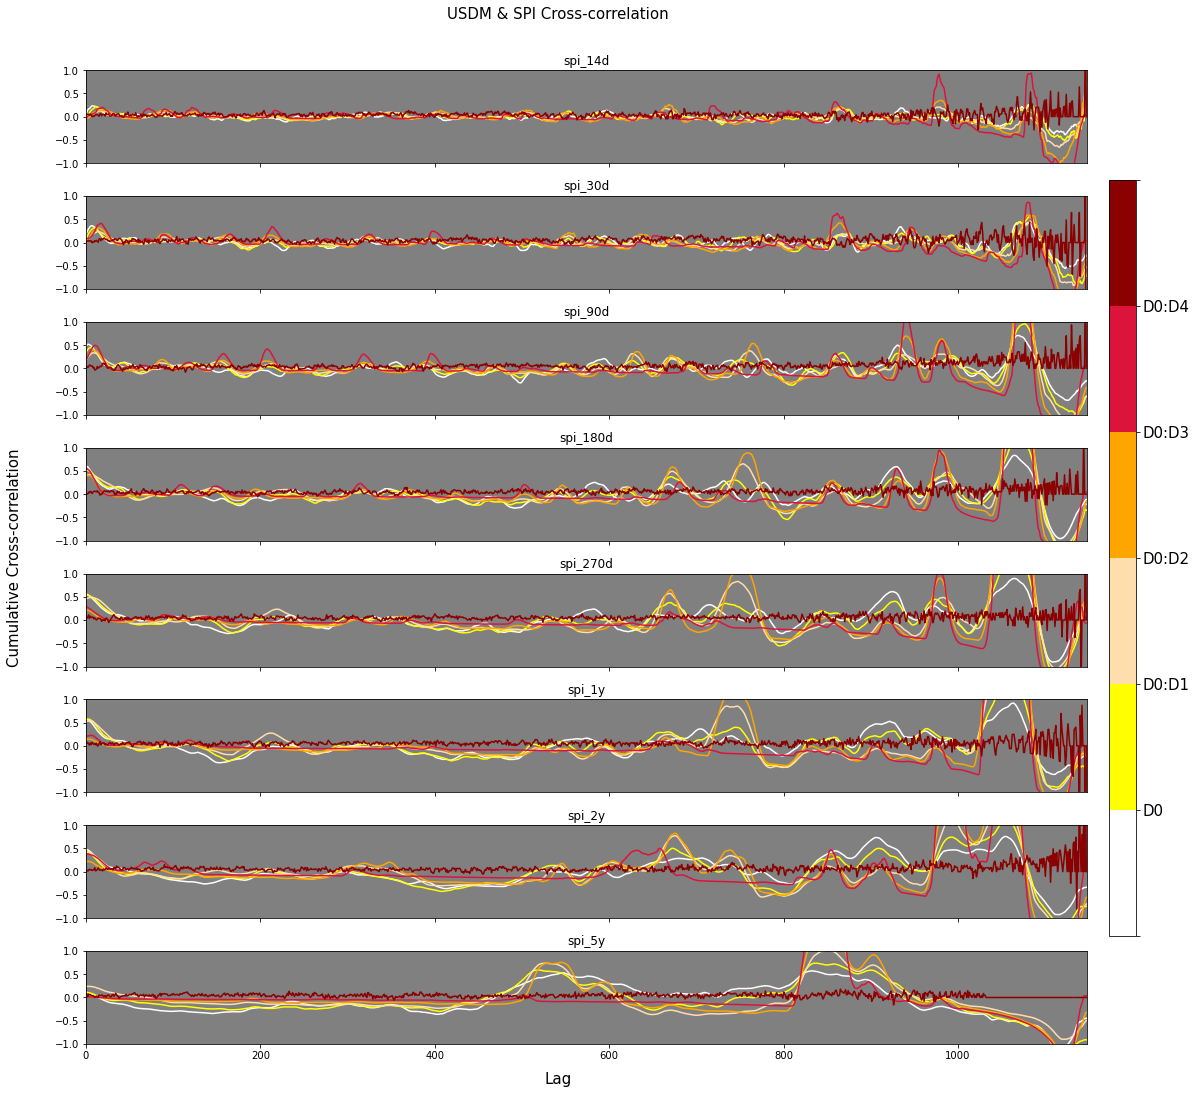

In [14]:
fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(15,15), sharex=True)


nlags = len(caf_ds['USDM Date'])

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    cumulative_usdm = np.zeros(len(caf_ds['index']))
    cumulative_spi = np.zeros(len(caf_ds['index']))
    for cat, color in zip(cats, usdm_colors):
        cumulative_usdm += caf_ds[f'USDM_{cat}']
        cumulative_spi += caf_ds[f'spi_{spi_int}_{cat}']
        ax.plot(np.arange(0, nlags), ccf(cumulative_usdm, cumulative_spi, ), color=color)
        #ax.plot(np.arange(0, nlags), ccf(cumulative_spi, cumulative_usdm,), color=color)

    ax.set_facecolor('grey')
    ax.set_title(f'spi_{spi_int}')
    ax.set_ylim(-1,1)
    ax.set_xlim(0, nlags)
    
cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cmap = ndplot.usdm_cmap()
bounds = np.linspace(-1, 5, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, ticks=bounds)
cbar.set_ticklabels(['', 'D0', 'D0:D1', 'D0:D2', 'D0:D3', 'D0:D4', ''], size=15)

fig.supylabel('Cumulative Cross-correlation', size=15, x=-0.01)
fig.supxlabel('Lag', size=15)
fig.suptitle('USDM & SPI Cross-correlation', size=15, y=1.01)

plt.tight_layout()

The correlation spikes with such a large lag is strange ... it's like several years or the whole time series ...

I think the cross correlation is done over the whole time series ... if I do something rolling is that better?

# 6.8.2022 Update

So one thing about all these is that it disregards spatial variations, for that check out `usdm_spi_pixel_compare.ipynb` ... and that it doesn't describe how the categories might be close but slightly off (also delved into more in that notebook). Last thing I want to do here on the aggregated scale is look at drought onset and length

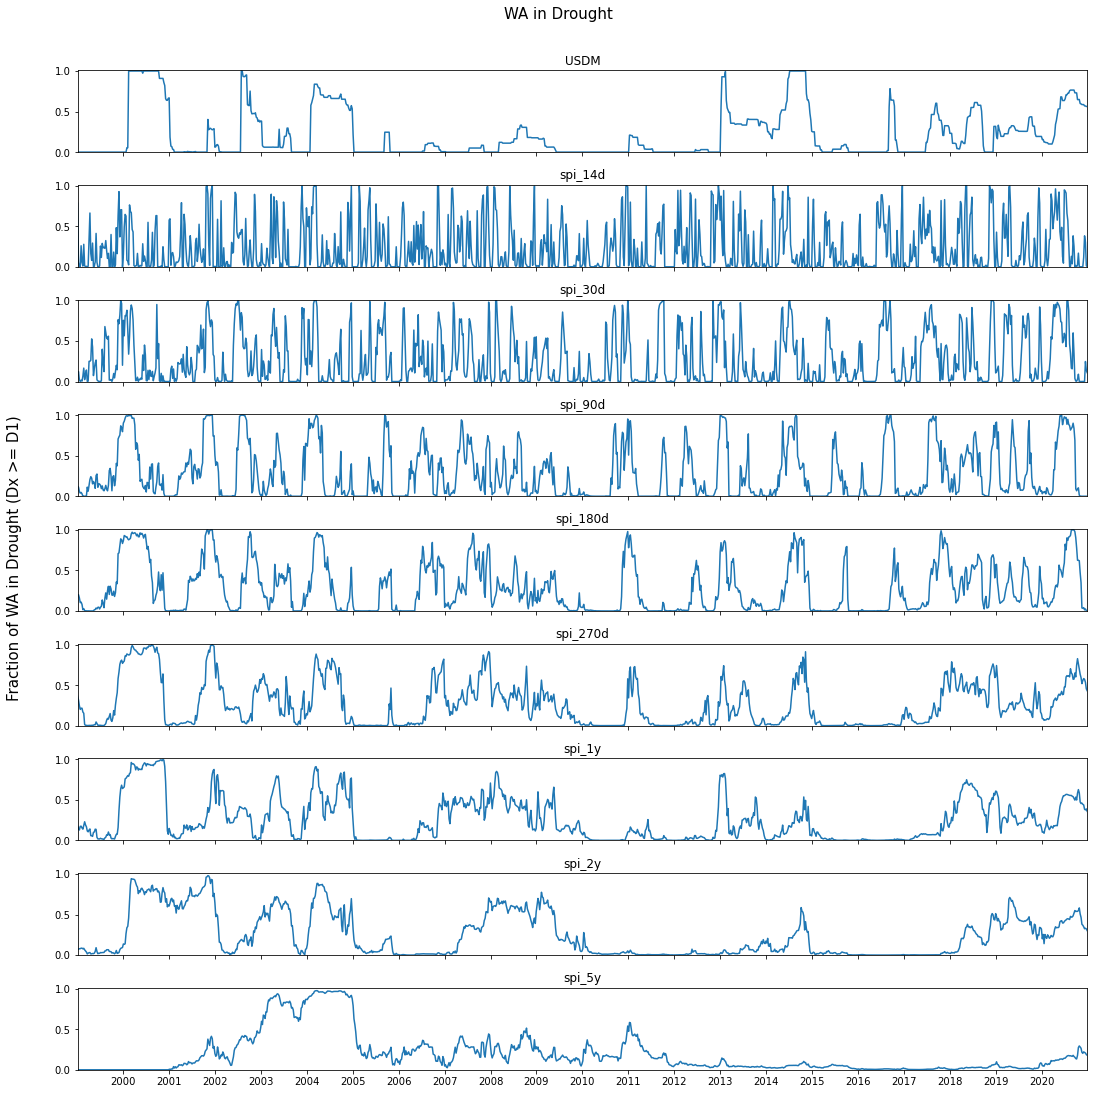

In [34]:
fig, axs = plt.subplots(len(dm_vars), 1, figsize=(15,15), sharex=True)

for ax, dm_var in zip(axs.ravel(), dm_vars):
    ax.plot(usdm_dates, 1-(caf_ds[f'{dm_var}_neutral_wet']+caf_ds[f'{dm_var}_D0']))
    ax.set_title(dm_var)

    ax.set_ylim(0, 1.01)
    ax.set_xlim(usdm_dates[0], usdm_dates[-1])

    # fix the formating to only show hours
    formatter = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(formatter)
    # set the frequency to not crowd the axis
    ax.set_xticks(pd.date_range(usdm_dates[0], usdm_dates[-1], freq='1Y'))

fig.supylabel('Fraction of WA in Drought (Dx >= D1)', x=-0.01, fontsize=15)
fig.suptitle('WA in Drought', y=1.01, fontsize=15)

plt.tight_layout()